# SPARCLCLIENT Example Usage

In [1]:
__author__ = 'Steve Pothier <steve.pothier@noirlab.edu>'
__version__ = '20240306' # yyyymmdd; 
__keywords__ = ['HowTo', 'astronomy', 'tutorial', 'client', 'sparcl', 'NOIRlab']

## Table of contents
* [Goals & Summary](#goals)
* [Imports and setup](#imports)
* [Install SPARCLCLIENT](#install)
* [Prepare to use sparcl](#prepare)
* [Get general info from SPARCL](#info)
* [Get Metadata and Spectra](#get)

<a class="anchor" id="goals"></a>
## Goals & Summary 
Demonstrate the use of the `sparclclient` package to get metadata and spectra data from the [NOIRLab SPARCL Server](https://astrosparcl.datalab.noirlab.edu/). Show how to get non-public data if you have authorized credentials.
- Discovery: Search for matching metadata and return metadata records.
- Retrieve spectra

<a class="anchor" id="imports"></a>
## Imports and Setup

In [2]:
from pprint import pformat as pf
from pprint import pp
import os.path
from importlib import reload
from collections import defaultdict
from datetime import datetime
import warnings
from getpass import getpass

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display, Markdown, Latex

class StopExecution(Exception):
    def _render_traceback_(self):
        pass

# %matplotlib inline
# requires installing ipympl
%matplotlib widget
plt.rcParams['font.size'] = 14

<a class="anchor" id="install"></a>
## Install most recent version of the SPARCLCLIENT
*NOTE: After installing the most recent version, please restart your kernel.*

In [3]:
# !pip install --upgrade sparclclient         # Latest released version
# !pip install --pre --upgrade sparclclient   # Lastest pre-released version

# Uncomment next line to load SPARCLCLIENT from local current version of software.
!pip install --pre --upgrade ../..

Processing /home/pothiers/sandbox/sparclclient
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for sparclclient: filename=sparclclient-1.2.2b8-py2.py3-none-any.whl size=3533665 sha256=fc035800e3269eccc70d3658f293c93d2fe7f07850a17cbdb47c9b2ce0de36ad
  Stored in directory: /tmp/pip-ephem-wheel-cache-lko1mvqq/wheels/9b/de/a2/3f7a82cf4ca7c9e775a1ed1daeea35010570464a1aaa8c370c
Successfully built sparclclient
  Attempting uninstall: sparclclient
    Found existing installation: sparclclient 1.2.2b8
    Uninstalling sparclclient-1.2.2b8:
      Successfully uninstalled sparclclient-1.2.2b8


In [4]:
import sparcl.client
print(f'Run started: {str(datetime.now())}')

Run started: 2024-05-02 10:22:12.795845


<a class="anchor" id="prepare"></a>
# Configure SPARCLCLIENT

In [5]:
# How much output to we want to show?
show_help = False   # HELP for client functions
show_curl = True   # Show the underlying SPARCL Server API call
verbose = True

server = 'https://astrosparcl.datalab.noirlab.edu'  # Public Server
server = 'https://sparc1.datalab.noirlab.edu'       # internal TEST Server
server = 'http://localhost:8050'                    # internal DEV Server

priv_dr = 'SDSS-DR17-test'
pub_dr = 'BOSS-DR16'

# Authenticated Users that are never authorized for anything important.
# These are authenticated on both Public and Test SSO servers.
auth_user   = 'test_user_1@noirlab.edu'
unauth_user = 'test_user_2@noirlab.edu'
non_user    = 'test_user_3@noirlab.edu'
usrpw = getpass()

 ········


In [6]:
if show_help:
    help(sparcl.client.SparclClient)
client = sparcl.client.SparclClient(url=server, show_curl=show_curl, verbose=verbose)
print(f'{client=}')

apiurl=http://localhost:8050/sparc
client=(sparclclient:1.2.2b8, api:11.0, http://localhost:8050/sparc, client_hash=f7bd410278bee26a425387c598dd47e80a8fcdcb, verbose=True, connect_timeout=1.1, read_timeout=5400.0)


<a class="anchor" id="info"></a>
# General Info from SPARCL

<a class="anchor" id="datasets"></a>
## Data sets available
List all currently available data sets from the server/url associated with client

In [7]:
client.all_datasets

{'BOSS-DR16', 'DESI-EDR', 'SDSS-DR16', 'SDSS-DR17-test'}

<a class="anchor" id="defaultfieldnames"></a>
## Default field names
Gets fields tagged as 'default' that are common to all data sets in the `dataset_list` passed to the function. If `dataset_list` is None (the default), the function returns the intersection of 'default' fields across all datasets currently available in the SPARC database. The following example of this function produces the same output as it would with no `dataset_list` argument because we currently only have SDSS-DR16 and BOSS-DR16 records in the SPARC database.

In [8]:
if show_help:
    client.get_default_fields?

In [9]:
client.get_default_fields(dataset_list=['SDSS-DR16', 'BOSS-DR16'])

['dec', 'flux', 'ra', 'sparcl_id', 'specid', 'wavelength']

<a class="anchor" id="allfieldnames"></a>
## All field names
Gets fields tagged as 'all' that are common to all data sets in the `dataset_list` passed to the function. If `dataset_list` is None (the default), the function returns the intersection of 'all' fields across all datasets currently available in the SPARC database.  The following example of this function produces the same output as it would with no `dataset_list` argument because we currently only have SDSS-DR16 and BOSS-DR16 records in the SPARC database.

In [10]:
client.get_all_fields?

Signature: client.get_all_fields(*, dataset_list=None)
Docstring:
Get fields tagged as 'all' that are in DATASET_LIST.
These are the fields used for the ALL value of the include parameter
of client.retrieve().

Args:
    dataset_list (:obj:`list`, optional): List of data sets from
        which to get all fields. Defaults to None, which
        will return the intersection of all fields in all
        data sets hosted on the SPARCL database.

Returns:
    List of fields tagged as 'all' from DATASET_LIST.

Example:
    >>> client = SparclClient()
    >>> client.get_all_fields()
    ['data_release', 'datasetgroup', 'dateobs', 'dateobs_center', 'dec', 'exptime', 'flux', 'instrument', 'ivar', 'mask', 'model', 'ra', 'redshift', 'redshift_err', 'redshift_warning', 'site', 'sparcl_id', 'specid', 'specprimary', 'spectype', 'survey', 'targetid', 'telescope', 'wave_sigma', 'wavelength', 'wavemax', 'wavemin']
File:      ~/sandbox/sparclclient/venv/lib/python3.10/site-packages/sparcl/client.py
Typ

In [11]:
print(sorted(client.get_all_fields(dataset_list=['SDSS-DR16', 'BOSS-DR16'])))

['ancillary_target1', 'ancillary_target2', 'anyandmask', 'anyormask', 'bluefiber', 'boss_specobj_id', 'boss_target1', 'boss_target2', 'calibflux', 'calibflux_ivar', 'chi68p', 'chunk', 'class_noqso', 'class_person', 'comments_person', 'cx', 'cy', 'cz', 'data_release', 'datasetgroup', 'dateobs', 'dateobs_center', 'dec', 'deredsn2', 'designid', 'dof', 'eboss_target0', 'eboss_target1', 'eboss_target2', 'eboss_target_id', 'elodie_bv', 'elodie_dof', 'elodie_feh', 'elodie_filename', 'elodie_logg', 'elodie_object', 'elodie_rchi2', 'elodie_sptype', 'elodie_teff', 'elodie_z', 'elodie_z_err', 'elodie_z_modelerr', 'exptime', 'fiberid', 'firstrelease', 'flux', 'fluxobjid', 'fracnsighi', 'fracnsiglo', 'fracnsigma', 'instrument', 'ivar', 'lambda_eff', 'legacy_target1', 'legacy_target2', 'marvels_target1', 'marvels_target2', 'mask', 'mjd', 'model', 'npoly', 'nspecobs', 'nturnoff', 'objid', 'plate', 'plateid', 'platequality', 'platerun', 'platesn2', 'primtarget', 'programname', 'ra', 'rchi2', 'rchi2dif

## Version of Server API used by this client
The SPARCL Client you use must match the version of the SPARCL Server you use. The server is specified with the client.SparclClient `url` parameter.  If Server and Client are incompatible, when you excecute SparclClient() you will instructed to upgrade your client.

In [12]:
client.version

11.0

<a class="anchor" id="get"></a>
# Get Metadata and Spectra

<a class="anchor" id="find"></a>
## Get Metadata: `client.find`

The first way you can discover your data is by using SPARCL's `client.find()` method, which allows you to find records in the SPARCL database based on certain parameters passed to the function. Only Core fields may be in the `outfields` and `constraints` parameters. The descriptions for all fields, including Core fields, is located [here](https://astrosparcl.datalab.noirlab.edu/sparc/sfc/). The SPARCL Core fields constraint types are:


| Field name       | Constraint type | Example |
|:----------------|:---------------|:-------|
| id               | List of values (but not<br>intended for data discovery) | ['00001658-460c-4da1-987d-e493d8c9b89b',<br>'000017b6-56a2-4f87-8828-3a3409ba1083']
| specid           | List of values | [6988698046080241664, 6971782884823945216]
| targetid         | List of values | [1237679502171374316, 1237678619584692841]
| data_release     | List of allowed values<br>from [SPARCL Categoricals](https://astrosparcl.datalab.noirlab.edu/sparc/cats/) | ['BOSS-DR16', 'SDSS-DR16']
| datasetgroup     | List of allowed values<br>from [SPARCL Categoricals](https://astrosparcl.datalab.noirlab.edu/sparc/cats/) | ['SDSS_BOSS']
| ra               | Range of values (may not<br>"wrap" around RA=0) | [44.53, 47.96]
| dec              | Range of values | [2.03, 7.76]
| redshift         | Range of values | [0.5, 0.9]
| redshift_err     | Range of values | [0.000225, 0.000516]
| redshift_warning | List of values  | [0, 3, 5]
| spectype         | List of allowed values<br>from [SPARCL Categoricals](https://astrosparcl.datalab.noirlab.edu/sparc/cats/) | ['GALAXY', 'STAR']
| instrument       | List of allowed values<br>from [SPARCL Categoricals](https://astrosparcl.datalab.noirlab.edu/sparc/cats/) | ['SDSS', 'BOSS']
| telescope        | List of allowed values<br>from [SPARCL Categoricals](https://astrosparcl.datalab.noirlab.edu/sparc/cats/) | ['sloan25m']
| site             | List of allowed values<br>from [SPARCL Categoricals](https://astrosparcl.datalab.noirlab.edu/sparc/cats/) |  ['apo']
| specprimary      | List of values (but typically<br>would only include 1 if<br>being used for data<br>discovery constraints) | [1]
| wavemin          | Range of values | [3607, 3608]
| wavemax          | Range of values | [10363, 10364]
| dateobs_center   | Range of values | ['2013-03-14T10:16:17Z',<br>'2014-05-24T12:10:00Z']
| exptime          | Range of values | [3603.46, 3810.12]
| updated          | Range of values | ['2022-08-20T21:37:50.636363Z',<br>'2022-09-20T20:00:00.000000Z']


In [13]:
if show_help:
    client.find?

#### Define fields and constraints for metadata FIND
Define the fields we want returned (`outfields`) and the constraints (`constraints`)

In [14]:
out = ['sparcl_id','specid', 'ra', 'dec', 'redshift', 'spectype', 'data_release', 'redshift_err']
cons = {'spectype': ['GALAXY'],
        'redshift': [0.5, 0.9],
        'data_release': ['BOSS-DR16', 'SDSS-DR16']}

#### Execute FIND
Execute the `client.find()` method with our parameters.
The `limit` argument here is being used for demonstration purposes only, and simply returns only the first 20 results here.

In [15]:
found = client.find(outfields=out, constraints=cons, limit=20)

url=http://localhost:8050/sparc/find/?limit=20 sspec={'outfields': ['sparcl_id', 'specid', 'ra', 'dec', 'redshift', 'spectype', 'data_release', 'redshift_err'], 'search': [['spectype', 'GALAXY'], ['redshift', 0.5, 0.9], ['data_release', 'BOSS-DR16', 'SDSS-DR16']]}
curl -X 'POST' -H 'Content-Type: application/json' -d '{"outfields": ["sparcl_id", "specid", "ra", "dec", "redshift", "spectype", "data_release", "redshift_err"], "search": [["spectype", "GALAXY"], ["redshift", 0.5, 0.9], ["data_release", "BOSS-DR16", "SDSS-DR16"]]}' 'http://localhost:8050/sparc/find/?limit=20' | python3 -m json.tool
Record key counts: {'spectype': 20, 'redshift': 20, 'sparcl_id': 20, 'ra': 20, 'dec': 20, 'specid': 20, '_dr': 20, 'data_release': 20, 'redshift_err': 20}


In [16]:
pd.DataFrame.from_records(found.records)

,redshift,ra,dec,data_release,specid,redshift_err,spectype,sparcl_id,_dr
0,0.545929,246.74298,35.985258,SDSS-DR16,1506516519029336064,0.000422,GALAXY,2c6c82dc-fe87-11ee-838b-08002725f1ef,SDSS-DR16
1,0.667431,245.40676,36.438884,SDSS-DR16,1506548404866541568,0.000026,GALAXY,3063feb6-fe87-11ee-8aa0-08002725f1ef,SDSS-DR16
2,0.502511,246.45702,36.657405,SDSS-DR16,1506572869000259584,0.000172,GALAXY,336d71cf-fe87-11ee-9390-08002725f1ef,SDSS-DR16
3,0.724874,246.89323,37.209662,SDSS-DR16,1506578916314212352,11.831918,GALAXY,342e5eaa-fe87-11ee-9047-08002725f1ef,SDSS-DR16
4,0.741196,247.40873,36.381456,SDSS-DR16,1506596508500256768,0.614932,GALAXY,36565b1b-fe87-11ee-b857-08002725f1ef,SDSS-DR16
5,0.675723,134.10755,28.038851,BOSS-DR16,-6444647351317147648,0.000241,GALAXY,5182df54-fe87-11ee-a660-08002725f1ef,BOSS-DR16
6,0.782685,134.23727,28.084685,BOSS-DR16,-6444646251805519872,0.000242,GALAXY,51ad9b94-fe87-11ee-af3e-08002725f1ef,BOSS-DR16
7,0.797439,133.98095,28.226386,BOSS-DR16,-6444643503026450432,0.000424,GALAXY,521321c8-fe87-11ee-946d-08002725f1ef,BOSS-DR16
8,0.647712,134.54531,28.429551,BOSS-DR16,-6444641304003194880,0.000238,GALAXY,52643970-fe87-11ee-abb3-08002725f1ef,BOSS-DR16
9,0.886086,134.46525,28.452505,BOSS-DR16,-6444640754247380992,0.000274,GALAXY,5278859e-fe87-11ee-8427-08002725f1ef,BOSS-DR16


<a class="anchor" id="retrieve"></a>
## Get Spectra: `client.retrieve`

In order to retrieve spectra records from SPARCL, pass the following to the `client.retrieve()` function:
```
uuid_list : List of IDs.
dataset_list : List of data sets to search for the IDs in (default: None).
include : List of field names to include in each record (default: 'DEFAULT').
```

**NOTE: A reasonable amount of records to request retrieval of is about 10,000. Exceeding this value may cause the retrieval to timeout or fail.**

In [17]:
if show_help:
    client.retrieve?

#### Use IDs from FIND to RETRIEVE records
Use the IDs from the output of using `client.find()` to retrieve records from SPARCL. 

Note that `ids` in `found_I.ids` is a property name of the Found class. It is a list of records from all records, not a field name of a record.

In [18]:
# Define the fields to include in the retrieve function
inc = ['specid', 'data_release', 'redshift', 'flux', 'wavelength', 'model', 'ivar', 'mask', 'spectype']

In [19]:
%%time
results = client.retrieve(uuid_list=found.ids,
                          include=inc,
                          dataset_list=['SDSS-DR16','BOSS-DR16'])
results.info

Using url="http://localhost:8050/sparc/spectras/?include=mask%2Cspectype%2Cmodel%2Credshift%2Cwavelength%2Cspecid%2Civar%2Cdata_release%2Cflux&format=pkl&dataset_list=SDSS-DR16%2CBOSS-DR16"
curl -X 'POST' -H 'Content-Type: application/json' -d '["2c6c82dc-fe87-11ee-838b-08002725f1ef", "3063feb6-fe87-11ee-8aa0-08002725f1ef", "336d71cf-fe87-11ee-9390-08002725f1ef", "342e5eaa-fe87-11ee-9047-08002725f1ef", "36565b1b-fe87-11ee-b857-08002725f1ef", "5182df54-fe87-11ee-a660-08002725f1ef", "51ad9b94-fe87-11ee-af3e-08002725f1ef", "521321c8-fe87-11ee-946d-08002725f1ef", "52643970-fe87-11ee-abb3-08002725f1ef", "5278859e-fe87-11ee-8427-08002725f1ef", "52913c34-fe87-11ee-844b-08002725f1ef", "52a796f0-fe87-11ee-b337-08002725f1ef", "52bbb47f-fe87-11ee-b8d7-08002725f1ef", "52cfb971-fe87-11ee-be51-08002725f1ef", "52e3cf35-fe87-11ee-b89c-08002725f1ef", "53203e47-fe87-11ee-b26f-08002725f1ef", "534af931-fe87-11ee-8467-08002725f1ef", "539b0add-fe87-11ee-b991-08002725f1ef", "53b9cd41-fe87-11ee-8132-08002725f

{'status': {'success': True,
  'info': ["Successfully found 20 records in dr_list=['SDSS-DR16', 'BOSS-DR16']"],
  'warnings': []}}

In [20]:
results.records[0]

{'redshift': 0.5459291338920593,
 'specid': 1506516519029336064,
 'spectype': 'GALAXY',
 'data_release': 'SDSS-DR16',
 '_dr': 'SDSS-DR16',
 'ivar': array([0., 0., 0., ..., 0., 0., 0.]),
 'mask': array([16777216, 16777216, 16777216, ..., 16777216, 16777216, 16777216]),
 'flux': array([1.23176956, 1.23148859, 1.23120809, ..., 4.00684404, 4.00690508,
        4.00696611]),
 'wavelength': array([3794.89706208, 3795.77097003, 3796.64507922, ..., 9217.22098659,
        9219.34357452, 9221.46665124]),
 'model': array([0.34971759, 0.35207507, 0.35443148, ..., 2.31373858, 2.30945611,
        2.30356026])}

## Plot spectra

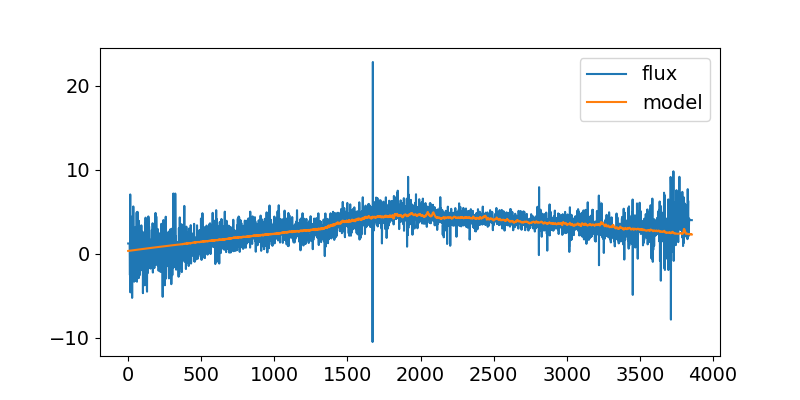

In [21]:
recs = results.records
idx = 0
fig=plt.figure(1, figsize=(8,4), dpi= 100, facecolor='w', edgecolor='k')
fline, = plt.plot(recs[idx].flux, label=f'flux')
mline, = plt.plot(recs[idx].model, label=f'model')
plt.legend(handles=[fline,mline])

## Plot FLUX for all records

In [22]:
print('Ignoring unsupported feature: align_records')

Ignoring unsupported feature: align_records


In [23]:
#import sparcl.gather_2d
#ar_dict, grid = sparcl.gather_2d.align_records(results.records)
#modeldf = pd.DataFrame(data=ar_dict['flux'],columns=grid)
#modeldf.transpose().plot(xlabel='Wavelength', ylabel='Flux', legend=False)

# Authorization
Your access to data is affected by how you login (or don't).  Both `client.find` and `client.retrieve` allow you to request data (possibly implictly) from specific Datasets. Its possible for your combination of LOGIN and FIND (or RETIEVE) to work now, but fail later without you changing anything. For instance, if you don't login and ask for data from ALL Datasets at a time when all Datasets are public, your FIND will succeed. But if NOIRLab adds a new Dataset that is private, your same find will fail. To avoid the failure, you would have to explicitly request only the public Datasets, or to login as a user that is authorized to access the private Dataset.

So summarize, there are three cases in which your FIND or RETRIEVE will be authorized:
1. All Datasets are Public (does not matter what you login status is)
2. You have explicitly requested only Public Datasets (does not matter what you login status is)
3. You are logged in and are authorized to access all the Private Datasets you have (explicitly or implicitly) requested.

You might be authorized to access one Dataset, but not another.  So, you must be careful in case #3 above to explictly request the correct Private Dataset(s).

## Logging in and logging out

In [24]:
if show_help:
    client.login?
    client.logout?

In [25]:
client.login(auth_user, usrpw)

Logged in successfully with email='test_user_1@noirlab.edu'


In [26]:
client.authorized

{'Loggedin_As': 'test_user_1@noirlab.edu',
 'Authorized_Datasets': {'BOSS-DR16',
  'DESI-EDR',
  'SDSS-DR16',
  'SDSS-DR17-test'}}

In [27]:
client.logout()   # can also be done with client.login(None)

Logged-out successfully.  Previously logged-in with email test_user_1@noirlab.edu.


In [28]:
client.authorized

{'Loggedin_As': 'Anonymous',
 'Authorized_Datasets': {'BOSS-DR16', 'DESI-EDR', 'SDSS-DR16'}}

## FIND

In [29]:
out = ['sparcl_id', 'data_release']

def pass_find(user, drs):
    client.login(user, usrpw)
    print(f'{client.authorized=}')
    try:
        if drs is None:
            found = client.find(outfields=out, limit=2)
        else:
            found = client.find(outfields=out, constraints=dict(data_release=drs), limit=2)
        print(f'\nSUCCESS: {found.count=} records from FIND: {user=}; {drs=}')
    except Exception as err:
        raise Exception(f'\nFAILED to get records from FIND: {user=}; {drs=}')

def fail_find(user, drs):
    client.login(user, usrpw)
    print(f'{client.authorized=}')

    try:
        found = client.find(outfields=out, constraints=dict(data_release=drs), limit=2)
        raise Exception(f'\nFAILED: Auth wrongly got {found.count} records in FIND: {user=}; {drs=}')
    except Exception as err:
        print(f'\nSUCCESS: Find did not get records. \n{err}')

### Pass FIND as Authorized with Default DRs

In [30]:
pass_find(auth_user, None)

Logged in successfully with email='test_user_1@noirlab.edu'
client.authorized={'Loggedin_As': 'test_user_1@noirlab.edu', 'Authorized_Datasets': {'SDSS-DR16', 'DESI-EDR', 'BOSS-DR16', 'SDSS-DR17-test'}}
url=http://localhost:8050/sparc/find/?limit=2 sspec={'outfields': ['sparcl_id', 'data_release'], 'search': []}
curl -X 'POST' -H 'Content-Type: application/json' -d '{"outfields": ["sparcl_id", "data_release"], "search": []}' 'http://localhost:8050/sparc/find/?limit=2' | python3 -m json.tool
Record key counts: {'data_release': 2, 'sparcl_id': 2, '_dr': 2}

SUCCESS: found.count=2 records from FIND: user='test_user_1@noirlab.edu'; drs=None


### Pass FIND as Authorized with Priv&Pub DRs

In [31]:
pass_find(auth_user, [pub_dr,priv_dr])

Logged in successfully with email='test_user_1@noirlab.edu'
client.authorized={'Loggedin_As': 'test_user_1@noirlab.edu', 'Authorized_Datasets': {'SDSS-DR16', 'DESI-EDR', 'BOSS-DR16', 'SDSS-DR17-test'}}
url=http://localhost:8050/sparc/find/?limit=2 sspec={'outfields': ['sparcl_id', 'data_release'], 'search': [['data_release', 'BOSS-DR16', 'SDSS-DR17-test']]}
curl -X 'POST' -H 'Content-Type: application/json' -d '{"outfields": ["sparcl_id", "data_release"], "search": [["data_release", "BOSS-DR16", "SDSS-DR17-test"]]}' 'http://localhost:8050/sparc/find/?limit=2' | python3 -m json.tool
Record key counts: {'data_release': 2, 'sparcl_id': 2, '_dr': 2}

SUCCESS: found.count=2 records from FIND: user='test_user_1@noirlab.edu'; drs=['BOSS-DR16', 'SDSS-DR17-test']


### Pass FIND as Unauthorized with Default DRs
DRs default to only what are authorized for authenticated user.

In [32]:
pass_find(unauth_user, None)

Logged in successfully with email='test_user_2@noirlab.edu'
client.authorized={'Loggedin_As': 'test_user_2@noirlab.edu', 'Authorized_Datasets': {'SDSS-DR16', 'DESI-EDR', 'BOSS-DR16'}}
url=http://localhost:8050/sparc/find/?limit=2 sspec={'outfields': ['sparcl_id', 'data_release'], 'search': []}
curl -X 'POST' -H 'Content-Type: application/json' -d '{"outfields": ["sparcl_id", "data_release"], "search": []}' 'http://localhost:8050/sparc/find/?limit=2' | python3 -m json.tool
Record key counts: {'data_release': 2, 'sparcl_id': 2, '_dr': 2}

SUCCESS: found.count=2 records from FIND: user='test_user_2@noirlab.edu'; drs=None


### Fail FIND as Unauthorized with Priv&Pub DRs

In [33]:
fail_find(unauth_user, [pub_dr,priv_dr])

Logged in successfully with email='test_user_2@noirlab.edu'
client.authorized={'Loggedin_As': 'test_user_2@noirlab.edu', 'Authorized_Datasets': {'SDSS-DR16', 'DESI-EDR', 'BOSS-DR16'}}
url=http://localhost:8050/sparc/find/?limit=2 sspec={'outfields': ['sparcl_id', 'data_release'], 'search': [['data_release', 'BOSS-DR16', 'SDSS-DR17-test']]}
curl -X 'POST' -H 'Content-Type: application/json' -d '{"outfields": ["sparcl_id", "data_release"], "search": [["data_release", "BOSS-DR16", "SDSS-DR17-test"]]}' 'http://localhost:8050/sparc/find/?limit=2' | python3 -m json.tool
Exception: response content=b'{"errorMessage": "test_user_2@noirlab.edu is declined access to datasets [\'SDSS-DR17-test\']; drs_requested=[\'BOSS-DR16\', \'SDSS-DR17-test\'] my_auth=[\'BOSS-DR16\', \'DESI-EDR\', \'SDSS-DR16\']", "errorCode": "NODRACCESS", "statusCode": 400, "saved_tb": "NoneType: None\\n"}'

SUCCESS: Find did not get records. 
[UNKNOWN] test_user_2@noirlab.edu is declined access to datasets ['SDSS-DR17-test'

### Pass FIND as Unknown with Default DRs
DRs default to only what are authorized for authenticated user.

In [34]:
pass_find(non_user, None)

Logged in successfully with email='test_user_3@noirlab.edu'
client.authorized={'Loggedin_As': 'Anonymous', 'Authorized_Datasets': {'SDSS-DR16', 'DESI-EDR', 'BOSS-DR16'}}
url=http://localhost:8050/sparc/find/?limit=2 sspec={'outfields': ['sparcl_id', 'data_release'], 'search': []}
curl -X 'POST' -H 'Content-Type: application/json' -d '{"outfields": ["sparcl_id", "data_release"], "search": []}' 'http://localhost:8050/sparc/find/?limit=2' | python3 -m json.tool
Record key counts: {'data_release': 2, 'sparcl_id': 2, '_dr': 2}

SUCCESS: found.count=2 records from FIND: user='test_user_3@noirlab.edu'; drs=None


### Fail FIND as Unknown with Priv&Pub DRs

In [35]:
fail_find(non_user, [pub_dr,priv_dr])

Logged in successfully with email='test_user_3@noirlab.edu'
client.authorized={'Loggedin_As': 'Anonymous', 'Authorized_Datasets': {'SDSS-DR16', 'DESI-EDR', 'BOSS-DR16'}}
url=http://localhost:8050/sparc/find/?limit=2 sspec={'outfields': ['sparcl_id', 'data_release'], 'search': [['data_release', 'BOSS-DR16', 'SDSS-DR17-test']]}
curl -X 'POST' -H 'Content-Type: application/json' -d '{"outfields": ["sparcl_id", "data_release"], "search": [["data_release", "BOSS-DR16", "SDSS-DR17-test"]]}' 'http://localhost:8050/sparc/find/?limit=2' | python3 -m json.tool
Exception: response content=b'{"errorMessage": "ANONYMOUS is declined access to datasets [\'SDSS-DR17-test\']; drs_requested=[\'BOSS-DR16\', \'SDSS-DR17-test\'] my_auth=[\'BOSS-DR16\', \'DESI-EDR\', \'SDSS-DR16\']", "errorCode": "NODRACCESS", "statusCode": 400, "saved_tb": "NoneType: None\\n"}'

SUCCESS: Find did not get records. 
[UNKNOWN] ANONYMOUS is declined access to datasets ['SDSS-DR17-test']; drs_requested=['BOSS-DR16', 'SDSS-DR17-

### Pass FIND as Anonymous with Default DR list 
DRs default to only what are authorized for authenticated user.

In [36]:
pass_find(None, None)

Logged-out successfully.  Previously logged-in with email test_user_3@noirlab.edu.
client.authorized={'Loggedin_As': 'Anonymous', 'Authorized_Datasets': {'SDSS-DR16', 'DESI-EDR', 'BOSS-DR16'}}
url=http://localhost:8050/sparc/find/?limit=2 sspec={'outfields': ['sparcl_id', 'data_release'], 'search': []}
curl -X 'POST' -H 'Content-Type: application/json' -d '{"outfields": ["sparcl_id", "data_release"], "search": []}' 'http://localhost:8050/sparc/find/?limit=2' | python3 -m json.tool
Record key counts: {'data_release': 2, 'sparcl_id': 2, '_dr': 2}

SUCCESS: found.count=2 records from FIND: user=None; drs=None


### Pass FIND as Anonymous with Public DR

In [37]:
pass_find(None, [pub_dr])

Logged-out successfully.  Previously logged-in with email None.
client.authorized={'Loggedin_As': 'Anonymous', 'Authorized_Datasets': {'SDSS-DR16', 'DESI-EDR', 'BOSS-DR16'}}
url=http://localhost:8050/sparc/find/?limit=2 sspec={'outfields': ['sparcl_id', 'data_release'], 'search': [['data_release', 'BOSS-DR16']]}
curl -X 'POST' -H 'Content-Type: application/json' -d '{"outfields": ["sparcl_id", "data_release"], "search": [["data_release", "BOSS-DR16"]]}' 'http://localhost:8050/sparc/find/?limit=2' | python3 -m json.tool
Record key counts: {'data_release': 2, 'sparcl_id': 2, '_dr': 2}

SUCCESS: found.count=2 records from FIND: user=None; drs=['BOSS-DR16']


### Fail FIND as Anonymous with Priv&Pub DRs

In [38]:
fail_find(None, [pub_dr, priv_dr])

Logged-out successfully.  Previously logged-in with email None.
client.authorized={'Loggedin_As': 'Anonymous', 'Authorized_Datasets': {'SDSS-DR16', 'DESI-EDR', 'BOSS-DR16'}}
url=http://localhost:8050/sparc/find/?limit=2 sspec={'outfields': ['sparcl_id', 'data_release'], 'search': [['data_release', 'BOSS-DR16', 'SDSS-DR17-test']]}
curl -X 'POST' -H 'Content-Type: application/json' -d '{"outfields": ["sparcl_id", "data_release"], "search": [["data_release", "BOSS-DR16", "SDSS-DR17-test"]]}' 'http://localhost:8050/sparc/find/?limit=2' | python3 -m json.tool
Exception: response content=b'{"errorMessage": "ANONYMOUS is declined access to datasets [\'SDSS-DR17-test\']; drs_requested=[\'BOSS-DR16\', \'SDSS-DR17-test\'] my_auth=[\'BOSS-DR16\', \'DESI-EDR\', \'SDSS-DR16\']", "errorCode": "NODRACCESS", "statusCode": 400, "saved_tb": "NoneType: None\\n"}'

SUCCESS: Find did not get records. 
[UNKNOWN] ANONYMOUS is declined access to datasets ['SDSS-DR17-test']; drs_requested=['BOSS-DR16', 'SDSS-D

## RETRIEVE

In [39]:
print(f'{client=}')
inc = ['sparcl_id', 'data_release']

#pub_ids = client.find(constraints=dict(data_release=[pub_dr]),limit=2).ids
#print(f'{pub_ids=}')
#priv_ids = client.find(constraints=dict(data_release=[priv_dr]),limit=2).ids
#print(f'{priv_ids=}')

def pass_retrieve(user, drs):
    client.login(user, usrpw)
    print(f'{client.authorized=}')

    if drs is None:
        ids = client.find(outfields=['sparcl_id'], limit=2).ids
    else:
        ids = client.find(outfields=['sparcl_id'], constraints=dict(data_release=drs), limit=2).ids
    try:
        if drs is None:
            got = client.retrieve(uuid_list=ids, include=inc, limit=2)
        else:
            got = client.retrieve(uuid_list=ids, include=inc, dataset_list=drs, limit=2)
        print(f'\nSUCCESS: {got.count=} records from RETRIEVE: {user=}; {drs=}')
    except Exception as err:
        raise Exception(f'Auth wrongly refused records from RETRIEVE: {user=}; {drs=}')

def fail_retrieve(user, drs):
    client.login(user, usrpw)
    print(f'{client.authorized=}')

    try:
        found = client.find(outfields=out, constraints=dict(data_release=drs), limit=2)
        raise Exception(f'Auth wrongly got {found.count} records in RETRIEVE: {user=}; {drs=}')
    except Exception as err:
        print(f'\nSUCCESS: RETRIEVE did not get records. \n{err}')

client=(sparclclient:1.2.2b8, api:11.0, http://localhost:8050/sparc, client_hash=f7bd410278bee26a425387c598dd47e80a8fcdcb, verbose=True, connect_timeout=1.1, read_timeout=5400.0)


### Pass RETRIEVE as Auth with Default DRs

In [40]:
pass_retrieve(auth_user, None)

Logged in successfully with email='test_user_1@noirlab.edu'
client.authorized={'Loggedin_As': 'test_user_1@noirlab.edu', 'Authorized_Datasets': {'SDSS-DR16', 'DESI-EDR', 'BOSS-DR16', 'SDSS-DR17-test'}}
url=http://localhost:8050/sparc/find/?limit=2 sspec={'outfields': ['sparcl_id'], 'search': []}
curl -X 'POST' -H 'Content-Type: application/json' -d '{"outfields": ["sparcl_id"], "search": []}' 'http://localhost:8050/sparc/find/?limit=2' | python3 -m json.tool
Record key counts: {'_dr': 2, 'sparcl_id': 2}
Using url="http://localhost:8050/sparc/spectras/?include=data_release%2Csparcl_id&format=pkl"
curl -X 'POST' -H 'Content-Type: application/json' -d '["000923d5-fe87-11ee-acd2-08002725f1ef", "0016db04-fe87-11ee-a58b-08002725f1ef"]' 'http://localhost:8050/sparc/spectras/?include=data_release%2Csparcl_id&format=pkl' | python3 -m json.tool
Got response to post in 0.23809996293857694 seconds
Got 2 spectra in 0.24 seconds (8 spectra/sec)
{'success': True, 'info': ["Successfully found 2 record

### Pass RETRIEVE as Auth with Priv&Pub DRs

In [41]:
pass_retrieve(auth_user, [priv_dr, pub_dr])

Logged in successfully with email='test_user_1@noirlab.edu'
client.authorized={'Loggedin_As': 'test_user_1@noirlab.edu', 'Authorized_Datasets': {'SDSS-DR16', 'DESI-EDR', 'BOSS-DR16', 'SDSS-DR17-test'}}
url=http://localhost:8050/sparc/find/?limit=2 sspec={'outfields': ['sparcl_id'], 'search': [['data_release', 'SDSS-DR17-test', 'BOSS-DR16']]}
curl -X 'POST' -H 'Content-Type: application/json' -d '{"outfields": ["sparcl_id"], "search": [["data_release", "SDSS-DR17-test", "BOSS-DR16"]]}' 'http://localhost:8050/sparc/find/?limit=2' | python3 -m json.tool
Record key counts: {'_dr': 2, 'sparcl_id': 2}
Using url="http://localhost:8050/sparc/spectras/?include=data_release%2Csparcl_id&format=pkl&dataset_list=SDSS-DR17-test%2CBOSS-DR16"
curl -X 'POST' -H 'Content-Type: application/json' -d '["510760cd-fe87-11ee-8470-08002725f1ef", "5111ce02-fe87-11ee-bea1-08002725f1ef"]' 'http://localhost:8050/sparc/spectras/?include=data_release%2Csparcl_id&format=pkl&dataset_list=SDSS-DR17-test%2CBOSS-DR16' | 

### Pass RETRIEVE as Unauth with Default DRs
DRs default to only what are authorized for authenticated user.

In [42]:
try:
    pass_retrieve(unauth_user, None)
except Exception as err:
    display(Markdown(f'#### BUG: {str(err)}'))

Logged in successfully with email='test_user_2@noirlab.edu'
client.authorized={'Loggedin_As': 'test_user_2@noirlab.edu', 'Authorized_Datasets': {'SDSS-DR16', 'DESI-EDR', 'BOSS-DR16'}}
url=http://localhost:8050/sparc/find/?limit=2 sspec={'outfields': ['sparcl_id'], 'search': []}
curl -X 'POST' -H 'Content-Type: application/json' -d '{"outfields": ["sparcl_id"], "search": []}' 'http://localhost:8050/sparc/find/?limit=2' | python3 -m json.tool
Record key counts: {'_dr': 2, 'sparcl_id': 2}
Using url="http://localhost:8050/sparc/spectras/?include=data_release%2Csparcl_id&format=pkl"
curl -X 'POST' -H 'Content-Type: application/json' -d '["000923d5-fe87-11ee-acd2-08002725f1ef", "0016db04-fe87-11ee-a58b-08002725f1ef"]' 'http://localhost:8050/sparc/spectras/?include=data_release%2Csparcl_id&format=pkl' | python3 -m json.tool
Got response to post in 0.26971720601432025 seconds
Got 2 spectra in 0.27 seconds (7 spectra/sec)
{'success': True, 'info': ["Successfully found 2 records in dr_list={'BOS

### Fail RETRIEVE as Unauth with Priv&Pub DRs

In [43]:
fail_retrieve(unauth_user, [priv_dr, pub_dr])

Logged in successfully with email='test_user_2@noirlab.edu'
client.authorized={'Loggedin_As': 'test_user_2@noirlab.edu', 'Authorized_Datasets': {'SDSS-DR16', 'DESI-EDR', 'BOSS-DR16'}}
url=http://localhost:8050/sparc/find/?limit=2 sspec={'outfields': ['sparcl_id', 'data_release'], 'search': [['data_release', 'SDSS-DR17-test', 'BOSS-DR16']]}
curl -X 'POST' -H 'Content-Type: application/json' -d '{"outfields": ["sparcl_id", "data_release"], "search": [["data_release", "SDSS-DR17-test", "BOSS-DR16"]]}' 'http://localhost:8050/sparc/find/?limit=2' | python3 -m json.tool
Exception: response content=b'{"errorMessage": "test_user_2@noirlab.edu is declined access to datasets [\'SDSS-DR17-test\']; drs_requested=[\'BOSS-DR16\', \'SDSS-DR17-test\'] my_auth=[\'BOSS-DR16\', \'DESI-EDR\', \'SDSS-DR16\']", "errorCode": "NODRACCESS", "statusCode": 400, "saved_tb": "NoneType: None\\n"}'

SUCCESS: RETRIEVE did not get records. 
[UNKNOWN] test_user_2@noirlab.edu is declined access to datasets ['SDSS-DR17-t

### Pass RETRIEVE as Unknown with Default DRs
DRs default to only what are authorized for authenticated user.

In [44]:
try:
    pass_retrieve(non_user, None)
except Exception as err:
    display(Markdown(f'#### BUG: {str(err)}'))

Logged in successfully with email='test_user_3@noirlab.edu'
client.authorized={'Loggedin_As': 'Anonymous', 'Authorized_Datasets': {'SDSS-DR16', 'DESI-EDR', 'BOSS-DR16'}}
url=http://localhost:8050/sparc/find/?limit=2 sspec={'outfields': ['sparcl_id'], 'search': []}
curl -X 'POST' -H 'Content-Type: application/json' -d '{"outfields": ["sparcl_id"], "search": []}' 'http://localhost:8050/sparc/find/?limit=2' | python3 -m json.tool
Record key counts: {'_dr': 2, 'sparcl_id': 2}
Using url="http://localhost:8050/sparc/spectras/?include=data_release%2Csparcl_id&format=pkl"
curl -X 'POST' -H 'Content-Type: application/json' -d '["000923d5-fe87-11ee-acd2-08002725f1ef", "0016db04-fe87-11ee-a58b-08002725f1ef"]' 'http://localhost:8050/sparc/spectras/?include=data_release%2Csparcl_id&format=pkl' | python3 -m json.tool
Got response to post in 0.3079184840898961 seconds
Got 2 spectra in 0.31 seconds (6 spectra/sec)
{'success': True, 'info': ["Successfully found 2 records in dr_list={'BOSS-DR16', 'DESI-

### Fail RETRIEVE as Unknown with Priv&Pub DRs

In [45]:
fail_retrieve(non_user, [priv_dr, pub_dr])

Logged in successfully with email='test_user_3@noirlab.edu'
client.authorized={'Loggedin_As': 'Anonymous', 'Authorized_Datasets': {'SDSS-DR16', 'DESI-EDR', 'BOSS-DR16'}}
url=http://localhost:8050/sparc/find/?limit=2 sspec={'outfields': ['sparcl_id', 'data_release'], 'search': [['data_release', 'SDSS-DR17-test', 'BOSS-DR16']]}
curl -X 'POST' -H 'Content-Type: application/json' -d '{"outfields": ["sparcl_id", "data_release"], "search": [["data_release", "SDSS-DR17-test", "BOSS-DR16"]]}' 'http://localhost:8050/sparc/find/?limit=2' | python3 -m json.tool
Exception: response content=b'{"errorMessage": "ANONYMOUS is declined access to datasets [\'SDSS-DR17-test\']; drs_requested=[\'BOSS-DR16\', \'SDSS-DR17-test\'] my_auth=[\'BOSS-DR16\', \'DESI-EDR\', \'SDSS-DR16\']", "errorCode": "NODRACCESS", "statusCode": 400, "saved_tb": "NoneType: None\\n"}'

SUCCESS: RETRIEVE did not get records. 
[UNKNOWN] ANONYMOUS is declined access to datasets ['SDSS-DR17-test']; drs_requested=['BOSS-DR16', 'SDSS-D

### Pass RETRIEVE as Anon with Default DRs
DRs default to only what are authorized for authenticated user.

In [46]:
try:
    pass_retrieve(None, None)
except Exception as err:
    display(Markdown(f'#### BUG: {str(err)}'))

Logged-out successfully.  Previously logged-in with email test_user_3@noirlab.edu.
client.authorized={'Loggedin_As': 'Anonymous', 'Authorized_Datasets': {'SDSS-DR16', 'DESI-EDR', 'BOSS-DR16'}}
url=http://localhost:8050/sparc/find/?limit=2 sspec={'outfields': ['sparcl_id'], 'search': []}
curl -X 'POST' -H 'Content-Type: application/json' -d '{"outfields": ["sparcl_id"], "search": []}' 'http://localhost:8050/sparc/find/?limit=2' | python3 -m json.tool
Record key counts: {'_dr': 2, 'sparcl_id': 2}
Using url="http://localhost:8050/sparc/spectras/?include=data_release%2Csparcl_id&format=pkl"
curl -X 'POST' -H 'Content-Type: application/json' -d '["000923d5-fe87-11ee-acd2-08002725f1ef", "0016db04-fe87-11ee-a58b-08002725f1ef"]' 'http://localhost:8050/sparc/spectras/?include=data_release%2Csparcl_id&format=pkl' | python3 -m json.tool
Got response to post in 0.03403094399254769 seconds
Got 2 spectra in 0.03 seconds (59 spectra/sec)
{'success': True, 'info': ["Successfully found 2 records in dr_

### Fail RETRIEVE as Anon with Priv&Pub DR 

In [47]:
fail_retrieve(None, [priv_dr, pub_dr])

Logged-out successfully.  Previously logged-in with email None.
client.authorized={'Loggedin_As': 'Anonymous', 'Authorized_Datasets': {'SDSS-DR16', 'DESI-EDR', 'BOSS-DR16'}}
url=http://localhost:8050/sparc/find/?limit=2 sspec={'outfields': ['sparcl_id', 'data_release'], 'search': [['data_release', 'SDSS-DR17-test', 'BOSS-DR16']]}
curl -X 'POST' -H 'Content-Type: application/json' -d '{"outfields": ["sparcl_id", "data_release"], "search": [["data_release", "SDSS-DR17-test", "BOSS-DR16"]]}' 'http://localhost:8050/sparc/find/?limit=2' | python3 -m json.tool
Exception: response content=b'{"errorMessage": "ANONYMOUS is declined access to datasets [\'SDSS-DR17-test\']; drs_requested=[\'BOSS-DR16\', \'SDSS-DR17-test\'] my_auth=[\'BOSS-DR16\', \'DESI-EDR\', \'SDSS-DR16\']", "errorCode": "NODRACCESS", "statusCode": 400, "saved_tb": "NoneType: None\\n"}'

SUCCESS: RETRIEVE did not get records. 
[UNKNOWN] ANONYMOUS is declined access to datasets ['SDSS-DR17-test']; drs_requested=['BOSS-DR16', 'SD

### Pass RETRIEVE as Anon with Public DR 

In [48]:
pass_retrieve(None, [pub_dr])

Logged-out successfully.  Previously logged-in with email None.
client.authorized={'Loggedin_As': 'Anonymous', 'Authorized_Datasets': {'SDSS-DR16', 'DESI-EDR', 'BOSS-DR16'}}
url=http://localhost:8050/sparc/find/?limit=2 sspec={'outfields': ['sparcl_id'], 'search': [['data_release', 'BOSS-DR16']]}
curl -X 'POST' -H 'Content-Type: application/json' -d '{"outfields": ["sparcl_id"], "search": [["data_release", "BOSS-DR16"]]}' 'http://localhost:8050/sparc/find/?limit=2' | python3 -m json.tool
Record key counts: {'_dr': 2, 'sparcl_id': 2}
Using url="http://localhost:8050/sparc/spectras/?include=data_release%2Csparcl_id&format=pkl&dataset_list=BOSS-DR16"
curl -X 'POST' -H 'Content-Type: application/json' -d '["510760cd-fe87-11ee-8470-08002725f1ef", "5111ce02-fe87-11ee-bea1-08002725f1ef"]' 'http://localhost:8050/sparc/spectras/?include=data_release%2Csparcl_id&format=pkl&dataset_list=BOSS-DR16' | python3 -m json.tool
Got response to post in 0.0383652689633891 seconds
Got 2 spectra in 0.04 seco

# All Done

In [49]:
print(f'Run finished: {str(datetime.now())}')

Run finished: 2024-05-02 10:22:39.403970


In [50]:
# DLS-496
client.login(auth_user, usrpw)
print(f'\n{client.authorized=}\n\n')
client.logout()   # can also be done with client.login(None)
print(f'\n{client.authorized=}')

Logged in successfully with email='test_user_1@noirlab.edu'

client.authorized={'Loggedin_As': 'test_user_1@noirlab.edu', 'Authorized_Datasets': {'SDSS-DR16', 'DESI-EDR', 'BOSS-DR16', 'SDSS-DR17-test'}}


Logged-out successfully.  Previously logged-in with email test_user_1@noirlab.edu.

client.authorized={'Loggedin_As': 'Anonymous', 'Authorized_Datasets': {'SDSS-DR16', 'DESI-EDR', 'BOSS-DR16'}}
